In [1]:
import os
import torch
import numpy as np

# CODE FILES HERE
from models.tdcvae.tdcvae import Encoder, Decoder, TD_Cvae, MODEL_NAME
from solver import Solver
from dataloader import DataLoader
from directories import Directories
from plots import plot_losses, plot_gaussian_distributions, plot_rl_kl, plot_latent_space,\
plot_latent_manifold, plot_prepro_params_distribution, plot_prepro_params_distribution_categories,\
plot_prepro_alpha_params_distribution, plot_prepro_radius_params_distribution, plot_faces_grid, plot_faces_samples_grid

# SETTINGS HERE
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # to see the CUDA stack
%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')
# VARIABLES HERE
load_model = False

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cpu



In [3]:
# Choose the dataset and tune hyperparameters here!
dataset = "MNIST"

optimizer = torch.optim.Adam
num_generations = 6

if dataset == "MNIST":
    batch_size = 128
    epochs = 1
    hidden_dim = 500
    z_dim = 2
    beta = 1 if z_dim == 2 else 1
    lr_scheduler = torch.optim.lr_scheduler.StepLR
    step_config = {
        "step_size" : 50,
        "gamma" : 0.1 # or 0.75
    }
    optim_config = {
        "lr": 1e-3,
        "weight_decay": None
    }
    thetas = {
        "theta_1": [0, 360],
        "theta_2": [0, 60]
    }
    scales = {
        "scale_1": [0.5, 0.9],
        "scale_2": [0.2, 0.4]
    }
if dataset == "LungScans":
    batch_size = 4
    epochs = 1
    hidden_dim = 1000
    z_dim = 2
    beta = 1 if z_dim == 2 else 1
    resize = (80, 80)
    lr_scheduler = torch.optim.lr_scheduler.StepLR
    step_config = {
        "step_size" : 200,
        "gamma" : 0.1 # or 0.75
    }
    optim_config = {
        "lr": 1e-3,
        "weight_decay": None
    }
    thetas = {
        "theta_1": [-45, 45],
        "theta_2": [-10, 10]
    }
    scales = {
        "scale_1": [0.5, 0.9],
        "scale_2": [0.2, 0.4]
    }

In [4]:
directories = Directories(MODEL_NAME, dataset, z_dim, False)
data_loader = DataLoader(directories, batch_size, dataset, num_generations=num_generations, thetas=thetas)
model = TD_Cvae(data_loader.input_dim, hidden_dim, data_loader.input_dim, z_dim)
solver = Solver(model, data_loader, optimizer, z_dim, epochs, beta, optim_config, step_config=step_config, lr_scheduler=lr_scheduler, tdcvae_mode=True)
solver.main()

+++++ START RUN +++++ | no save mode
0
new theta1 and theta2! 128
new theta1 and theta2! 256
new theta1 and theta2! 384
new theta1 and theta2! 512
new theta1 and theta2! 640
6
new theta1 and theta2! 896
new theta1 and theta2! 1024
new theta1 and theta2! 1152
new theta1 and theta2! 1280
new theta1 and theta2! 1408
12
new theta1 and theta2! 1664
new theta1 and theta2! 1792
new theta1 and theta2! 1920
new theta1 and theta2! 2048
new theta1 and theta2! 2176
18
new theta1 and theta2! 2432
new theta1 and theta2! 2560
new theta1 and theta2! 2688
new theta1 and theta2! 2816
new theta1 and theta2! 2944
24
new theta1 and theta2! 3200
new theta1 and theta2! 3328
new theta1 and theta2! 3456
new theta1 and theta2! 3584
new theta1 and theta2! 3712
30
new theta1 and theta2! 3968
new theta1 and theta2! 4096
new theta1 and theta2! 4224
new theta1 and theta2! 4352
new theta1 and theta2! 4480
36
new theta1 and theta2! 4736
new theta1 and theta2! 4864
new theta1 and theta2! 4992
new theta1 and theta2! 512

new theta1 and theta2! 42624
new theta1 and theta2! 42752
new theta1 and theta2! 42880
336
new theta1 and theta2! 43136
new theta1 and theta2! 43264
new theta1 and theta2! 43392
new theta1 and theta2! 43520
new theta1 and theta2! 43648
342
new theta1 and theta2! 43904
new theta1 and theta2! 44032
new theta1 and theta2! 44160
new theta1 and theta2! 44288
new theta1 and theta2! 44416
348
new theta1 and theta2! 44672
new theta1 and theta2! 44800
new theta1 and theta2! 44928
new theta1 and theta2! 45056
new theta1 and theta2! 45184
354
new theta1 and theta2! 45440
new theta1 and theta2! 45568
new theta1 and theta2! 45696
new theta1 and theta2! 45824
new theta1 and theta2! 45952
360
new theta1 and theta2! 46208
new theta1 and theta2! 46336
new theta1 and theta2! 46464
new theta1 and theta2! 46592
new theta1 and theta2! 46720
366
new theta1 and theta2! 46976
new theta1 and theta2! 47104
new theta1 and theta2! 47232
new theta1 and theta2! 47360
new theta1 and theta2! 47488
372
new theta1 and 

new theta1 and theta2! 84992
new theta1 and theta2! 85120
666
new theta1 and theta2! 85376
new theta1 and theta2! 85504
new theta1 and theta2! 85632
new theta1 and theta2! 85760
new theta1 and theta2! 85888
672
new theta1 and theta2! 86144
new theta1 and theta2! 86272
new theta1 and theta2! 86400
new theta1 and theta2! 86528
new theta1 and theta2! 86656
678
new theta1 and theta2! 86912
new theta1 and theta2! 87040
new theta1 and theta2! 87168
new theta1 and theta2! 87296
new theta1 and theta2! 87424
684
new theta1 and theta2! 87680
new theta1 and theta2! 87808
new theta1 and theta2! 87936
new theta1 and theta2! 88064
new theta1 and theta2! 88192
690
new theta1 and theta2! 88448
new theta1 and theta2! 88576
new theta1 and theta2! 88704
new theta1 and theta2! 88832
new theta1 and theta2! 88960
696
new theta1 and theta2! 89216
new theta1 and theta2! 89344
new theta1 and theta2! 89472
new theta1 and theta2! 89600
new theta1 and theta2! 89728
702
new theta1 and theta2! 89984
new theta1 and 

new theta1 and theta2! 126464
new theta1 and theta2! 126592
990
new theta1 and theta2! 126848
new theta1 and theta2! 126976
new theta1 and theta2! 127104
new theta1 and theta2! 127232
new theta1 and theta2! 127360
996
new theta1 and theta2! 127616
new theta1 and theta2! 127744
new theta1 and theta2! 127872
new theta1 and theta2! 128000
new theta1 and theta2! 128128
1002
new theta1 and theta2! 128384
new theta1 and theta2! 128512
new theta1 and theta2! 128640
new theta1 and theta2! 128768
new theta1 and theta2! 128896
1008
new theta1 and theta2! 129152
new theta1 and theta2! 129280
new theta1 and theta2! 129408
new theta1 and theta2! 129536
new theta1 and theta2! 129664
1014
new theta1 and theta2! 129920
new theta1 and theta2! 130048
new theta1 and theta2! 130176
new theta1 and theta2! 130304
new theta1 and theta2! 130432
1020
new theta1 and theta2! 130688
new theta1 and theta2! 130816
new theta1 and theta2! 130944
new theta1 and theta2! 131072
new theta1 and theta2! 131200
1026
new the

new theta1 and theta2! 167168
new theta1 and theta2! 167296
1308
new theta1 and theta2! 167552
new theta1 and theta2! 167680
new theta1 and theta2! 167808
new theta1 and theta2! 167936
new theta1 and theta2! 168064
1314
new theta1 and theta2! 168320
new theta1 and theta2! 168448
new theta1 and theta2! 168576
new theta1 and theta2! 168704
new theta1 and theta2! 168832
1320
new theta1 and theta2! 169088
new theta1 and theta2! 169216
new theta1 and theta2! 169344
new theta1 and theta2! 169472
new theta1 and theta2! 169600
1326
new theta1 and theta2! 169856
new theta1 and theta2! 169984
new theta1 and theta2! 170112
new theta1 and theta2! 170240
new theta1 and theta2! 170368
1332
new theta1 and theta2! 170624
new theta1 and theta2! 170752
new theta1 and theta2! 170880
new theta1 and theta2! 171008
new theta1 and theta2! 171136
1338
new theta1 and theta2! 171392
new theta1 and theta2! 171520
new theta1 and theta2! 171648
new theta1 and theta2! 171776
new theta1 and theta2! 171904
1344
new t

new theta1 and theta2! 207872
new theta1 and theta2! 208000
1626
new theta1 and theta2! 208256
new theta1 and theta2! 208384
new theta1 and theta2! 208512
new theta1 and theta2! 208640
new theta1 and theta2! 208768
1632
new theta1 and theta2! 209024
new theta1 and theta2! 209152
new theta1 and theta2! 209280
new theta1 and theta2! 209408
new theta1 and theta2! 209536
1638
new theta1 and theta2! 209792
new theta1 and theta2! 209920
new theta1 and theta2! 210048
new theta1 and theta2! 210176
new theta1 and theta2! 210304
1644
new theta1 and theta2! 210560
new theta1 and theta2! 210688
new theta1 and theta2! 210816
new theta1 and theta2! 210944
new theta1 and theta2! 211072
1650
new theta1 and theta2! 211328
new theta1 and theta2! 211456
new theta1 and theta2! 211584
new theta1 and theta2! 211712
new theta1 and theta2! 211840
1656
new theta1 and theta2! 212096
new theta1 and theta2! 212224
new theta1 and theta2! 212352
new theta1 and theta2! 212480
new theta1 and theta2! 212608
1662
new t

new theta1 and theta2! 248576
new theta1 and theta2! 248704
1944
new theta1 and theta2! 248960
new theta1 and theta2! 249088
new theta1 and theta2! 249216
new theta1 and theta2! 249344
new theta1 and theta2! 249472
1950
new theta1 and theta2! 249728
new theta1 and theta2! 249856
new theta1 and theta2! 249984
new theta1 and theta2! 250112
new theta1 and theta2! 250240
1956
new theta1 and theta2! 250496
new theta1 and theta2! 250624
new theta1 and theta2! 250752
new theta1 and theta2! 250880
new theta1 and theta2! 251008
1962
new theta1 and theta2! 251264
new theta1 and theta2! 251392
new theta1 and theta2! 251520
new theta1 and theta2! 251648
new theta1 and theta2! 251776
1968
new theta1 and theta2! 252032
new theta1 and theta2! 252160
new theta1 and theta2! 252288
new theta1 and theta2! 252416
new theta1 and theta2! 252544
1974
new theta1 and theta2! 252800
new theta1 and theta2! 252928
new theta1 and theta2! 253056
new theta1 and theta2! 253184
new theta1 and theta2! 253312
1980
new t

new theta1 and theta2! 289280
new theta1 and theta2! 289408
2262
new theta1 and theta2! 289664
new theta1 and theta2! 289792
new theta1 and theta2! 289920
new theta1 and theta2! 290048
new theta1 and theta2! 290176
2268
new theta1 and theta2! 290432
new theta1 and theta2! 290560
new theta1 and theta2! 290688
new theta1 and theta2! 290816
new theta1 and theta2! 290944
2274
new theta1 and theta2! 291200
new theta1 and theta2! 291328
new theta1 and theta2! 291456
new theta1 and theta2! 291584
new theta1 and theta2! 291712
2280
new theta1 and theta2! 291968
new theta1 and theta2! 292096
new theta1 and theta2! 292224
new theta1 and theta2! 292352
new theta1 and theta2! 292480
2286
new theta1 and theta2! 292736
new theta1 and theta2! 292864
new theta1 and theta2! 292992
new theta1 and theta2! 293120
new theta1 and theta2! 293248
2292
new theta1 and theta2! 293504
new theta1 and theta2! 293632
new theta1 and theta2! 293760
new theta1 and theta2! 293888
new theta1 and theta2! 294016
2298
new t

new theta1 and theta2! 329984
new theta1 and theta2! 330112
2580
new theta1 and theta2! 330368
new theta1 and theta2! 330496
new theta1 and theta2! 330624
new theta1 and theta2! 330752
new theta1 and theta2! 330880
2586
new theta1 and theta2! 331136
new theta1 and theta2! 331264
new theta1 and theta2! 331392
new theta1 and theta2! 331520
new theta1 and theta2! 331648
2592
new theta1 and theta2! 331904
new theta1 and theta2! 332032
new theta1 and theta2! 332160
new theta1 and theta2! 332288
new theta1 and theta2! 332416
2598
new theta1 and theta2! 332672
new theta1 and theta2! 332800
new theta1 and theta2! 332928
new theta1 and theta2! 333056
new theta1 and theta2! 333184
2604
new theta1 and theta2! 333440
new theta1 and theta2! 333568
new theta1 and theta2! 333696
new theta1 and theta2! 333824
new theta1 and theta2! 333952
2610
new theta1 and theta2! 334208
new theta1 and theta2! 334336
new theta1 and theta2! 334464
new theta1 and theta2! 334592
new theta1 and theta2! 334720
2616
new t

In [ ]:
#solver = torch.load("../results/saved_models/model_TD_CVAE_SCALES_THETAS_MNIST_train_loss=151.99_z=2.pt", map_location='cpu')
#solver.model.eval()
#load_model = True

In [ ]:
# TODO: make something like a dict to insert for plot titles to avoid it has to be taken from solver obj and 
# instead we can los from dumb also.

In [ ]:
# Plotting train and test losses for all epochs
plot_losses(solver, solver.train_loss_history["train_loss_acc"], solver.test_loss_history)

In [ ]:
# Plotting the gaussian of z space and some metrics about the space
plot_gaussian_distributions(solver, len(solver.train_loss_history["train_loss_acc"]))

In [ ]:
# Monitoring the reconstruction loss (likelihood lower bound) and KL divergence
DEBUG = 0
if DEBUG:
    for epoch, train_loss, test_loss, rl, kl in zip(solver.train_loss_history["epochs"], \
        solver.train_loss_history["train_loss_acc"], solver.test_loss_history, \
        solver.train_loss_history["recon_loss_acc"], solver.train_loss_history["kl_diverg_acc"]):
        print("epoch: {}, train_loss: {:.2f}, test_loss: {:.2f}, recon. loss: {:.2f}, KL div.: {:.2f}".format(
            epoch, train_loss, test_loss, rl, kl))
        print("overfitting: {:.2f}".format(abs(test_loss-train_loss)))
plot_rl_kl(solver, solver.train_loss_history["recon_loss_acc"], solver.train_loss_history["kl_diverg_acc"])

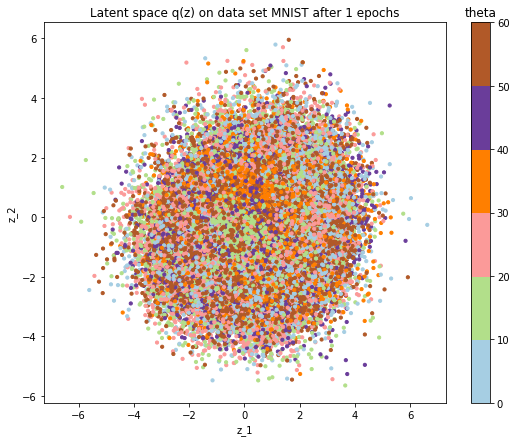

In [5]:
# visualize q(z) (latent space z)
if solver.z_dim == 2:
    for key in solver.data_loader.prepro_params.keys():
        if key == "theta_diff" or key == "scale_diff" and solver.data_loader.prepro_params[key].any():
            if key == "theta_diff":
                ticks = np.arange(solver.data_loader.theta_range_2[0], solver.data_loader.theta_range_2[1]+1, 10).tolist()
            if key == "scale_diff":
                ticks = np.linspace(solver.data_loader.scale_range_2[0], solver.data_loader.scale_range_2[1], 6).tolist()
            plot_latent_space(solver, solver.z_space[-1], ticks, "z", key.split("_")[0], solver.data_loader.prepro_params["theta_diff"][-1])
else:
    print("Plot of latent space not possible as dimension of z is not 2")

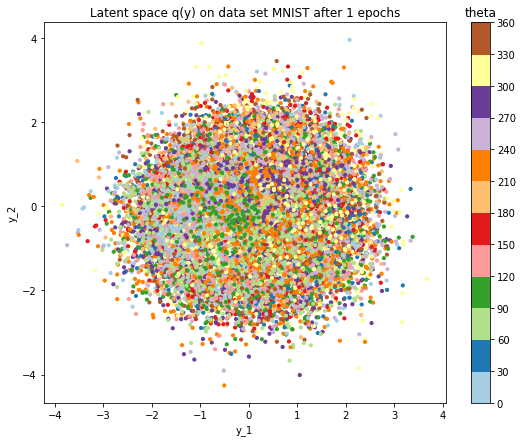

In [7]:
# visualize q(y)
if solver.z_dim == 2:
    for key in solver.data_loader.prepro_params.keys():
        if key == "theta_1" or key == "scale_1":
            if key == "theta_1":
                ticks = np.arange(solver.data_loader.theta_range_1[0], solver.data_loader.theta_range_1[1]+1, 30).tolist()
            if key == "scale_1":
                ticks = [round(0.1*x,1) for x in range(int(solver.data_loader.scale_range_1[0]*10),\
                                                       int(solver.data_loader.scale_range_1[1]+0.1)*10)]
            plot_latent_space(solver, solver.y_space[-1], ticks, "y", key.split("_")[0], solver.data_loader.prepro_params[key][-1])
else:
    print("Plot of y space not possible as dimension of z is not 2")

2808


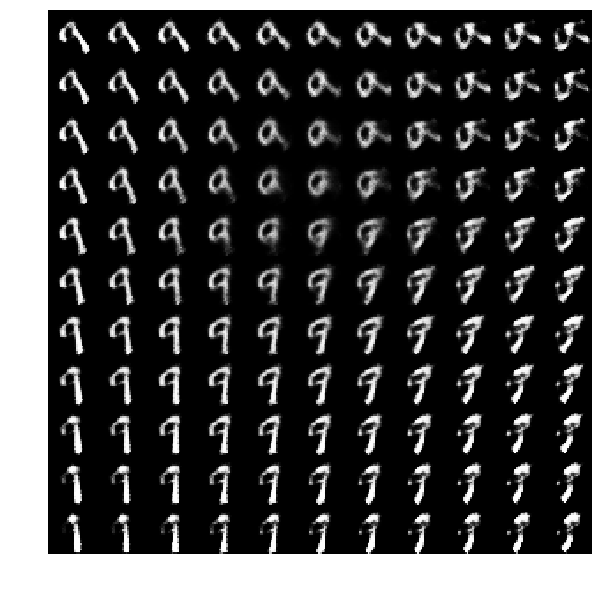

In [8]:
# Visualizations of learned data manifold for generative models with two-dimensional latent space
if not load_model:   
    if solver.z_dim == 2:
        n = 11
        if solver.data_loader.thetas:
            grid_x = np.linspace(-4, 4, n)
            grid_y = np.linspace(-4, 4, n)
        elif solver.data_loader.scales:
            grid_x = np.linspace(-3, 3, n)
            grid_y = np.linspace(-3, 3, n)
        x_t = iter(solver.data_loader.train_loader).next()[0][0][0].view(-1, solver.data_loader.input_dim)
        plot_latent_manifold(solver, "bone", grid_x, grid_y, n, x_t=x_t)
    else:
        print("Plot is not possible as dimension of z is not 2")

In [ ]:
# Bar chart over the different theta_1/scale_1 used for y_t
if solver.z_dim == 2:
    for key in solver.data_loader.prepro_params.keys():
        if key == "theta_1" or key == "scale_1":
            if key == "theta_1":
                xticks = np.arange(solver.data_loader.theta_range_1[0], solver.data_loader.theta_range_1[1]+1, 30).tolist()
                plot_prepro_params_distribution(solver, xticks, key, "Angle distribution for y_t", "Count")
            if key == "scale_1":
                xticks = [round(0.1*x,1) for x in range(int(solver.data_loader.scale_range_1[0]*10),\
                                                       int(solver.data_loader.scale_range_1[1]+0.1)*10)]
                plot_prepro_params_distribution(solver, xticks, key, "Scaling distribution for y_t", "Count")
else:
    print("Plot of y space not possible as dimension of z is not 2")

In [ ]:
# distribution of angles/scales with categeries/classes of dataset as bins
if solver.z_dim == 2 and solver.data_loader.with_labels:
    for key in solver.data_loader.prepro_params.keys():
        if key == "theta_1" or key == "scale_1":
            ytitle = "Number of elements in each bin"
            if key == "theta_1":
                xticks = np.arange(solver.data_loader.theta_range_1[0], solver.data_loader.theta_range_1[1]+1, 30).tolist()
                plot_prepro_params_distribution_categories(solver, xticks, key, "Distribution of angles by labels", ytitle)
            if key == "scale_1":
                xticks = [round(0.1*x,1) for x in range(int(solver.data_loader.scale_range_1[0]*10),\
                                                       int(solver.data_loader.scale_range_1[1]+0.1)*10)]
                plot_prepro_params_distribution_categories(solver, xticks, key, "Distribution of scales by labels", ytitle)
else:
    print("Plot of y space not possible as dimension of z is not 2 or no labeled data")

In [ ]:
if solver.z_dim == 2:
    for key in solver.data_loader.prepro_params.keys():
        if key == "theta_1":
            alphas = torch.atan2(torch.tensor(solver.y_space[:,0]-np.mean(solver.y_space[:,0])), torch.tensor(solver.y_space[:,1]-np.mean(solver.y_space[:,1])))/(2*np.pi)
            alphas = [round(x,2) for x in alphas.tolist()]
            alpha_ranges = np.around(np.linspace(np.min(alphas), np.max(alphas), 13), decimals=2)
            alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
            xticks = np.arange(solver.data_loader.theta_range_1[0], solver.data_loader.theta_range_1[1]+1, 30).tolist() # theta bins
            theta_alpha = list(zip(solver.data_loader.prepro_params[key], alphas)) # each theta_1 and alpha_1 paired
            plot_prepro_params_distribution(solver, xticks, key, "Archtangents distribution for y_t", "alpha distribution for theta_1 bins", data=(theta_alpha, alpha_bins))
else:
    print("Plot of y space not possible as dimension of z is not 2")

In [ ]:
if solver.z_dim == 2 and solver.data_loader.with_labels:
    for key in solver.data_loader.prepro_params.keys():
        if key == "theta_1":
            alphas = torch.atan2(torch.tensor(solver.y_space[:,0]-np.mean(solver.y_space[:,0])), torch.tensor(solver.y_space[:,1]-np.mean(solver.y_space[:,1])))/(2*np.pi)
            alphas = [round(x,2) for x in alphas.tolist()]
            alpha_ranges = np.around(np.linspace(np.min(alphas), np.max(alphas), 13), decimals=2)
            alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
            theta_bins = np.arange(solver.data_loader.theta_range_1[0], solver.data_loader.theta_range_1[1]+1, 30).tolist() # theta bins
            theta_alpha_label = list(zip(solver.data_loader.prepro_params[key], alphas, solver.data_labels)) # each theta_1i, alpha_1i, y_i paired
            plot_prepro_params_distribution_categories(solver, theta_bins, key, "Distribution of archtangents by labels", "alpha distribution for theta_1 in bins", data=(theta_alpha_label, alpha_bins))
else:
    print("Plot of y space not possible as dimension of z is not 2")

In [ ]:
# for rotation
if solver.z_dim == 2 and solver.data_loader.thetas:
    plot_prepro_alpha_params_distribution(solver)
else:
    print("dim(z) is not 2 or rotation mode is not set")

In [ ]:
# for scaling
if solver.z_dim == 2 and solver.data_loader.scales:
    plot_prepro_radius_params_distribution(solver)
else:
    print("dim(z) is not 2 or scaling mode is not set")

In [ ]:
thetas = np.radians(solver.data_loader.prepro_params["theta_1"])
#print(thetas.shape, thetas[:,0].T)
#print(thetas[:,0].T.shape)
#print(np.repeat(thetas[:,0].T, solver.data_loader.num_train_samples))
#print(np.repeat(solver.data_loader.prepro_params["theta_1"][:,0].T, solver.data_loader.num_train_samples))
print(len(solver.data_loader.prepro_params["theta_1"][:, 0]))
#print(solver.y_space.shape)
M, N, D = solver.y_space.shape
print(solver.y_space.reshape((N, M, D)).shape)
print(solver.data_loader.prepro_params["theta_1"][0,:])

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats as stats
import scipy.spatial.distance as bla


alphas = torch.atan2(torch.tensor(solver.y_space[:,:,0]-np.mean(solver.y_space[:,:,0])), torch.tensor(solver.y_space[:,:,1]-np.mean(solver.y_space[:,:,1])))/(2*np.pi)
alphas = np.around(np.array(alphas), decimals=2)
# TODO:
alphas = alphas[0,:]
classes = solver.data_labels
alpha_ranges = np.around(np.linspace(np.min(alphas), np.max(alphas), 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:]))

# TODO: fix thetas...
print(alphas.shape)
thetas = solver.data_loader.prepro_params["theta_1"][0] #np.radians(solver.data_loader.prepro_params["theta_1"][0].T)
print(thetas)
print(np.min(thetas), np.max(thetas))

#paired_cmap = plt.cm.get_cmap("Paired", 12)
#rvb = mcolors.LinearSegmentedColormap.from_list("", paired_cmap.colors)
alpha_ranges = alpha_ranges[:-1]
#norm = (alpha_ranges - np.min(alpha_ranges))/np.ptp(alpha_ranges)
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices]
    for alpha in alphas_indices:
        for bin_idx, (x, y) in enumerate(alpha_bins):
            if x <= alpha and alpha < y:
                counts[bin_idx] += 1
                break
    print(counts)
    new_counts = np.zeros(len(alphas_indices))
    asd = 0
    for idx, count in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    print(len(thetas), len(new_counts), indices, np.min(thetas[indices]), np.max(thetas[indices]))
    scatter = ax.scatter(thetas[indices], alphas_indices, c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)
plt.show()

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats as stats
import scipy.spatial.distance as bla
solver = torch.load("../results/saved_models/model_TD_CVAE_MNIST_train_loss=88.61_z=2.pt", map_location='cpu')
#solver = torch.load("../results/saved_models/model_TD_CVAE_THETAS_MNIST_train_loss=86.61_z=2.pt", map_location='cpu')
solver.model.eval()


alphas = torch.atan2(torch.tensor(solver.y_space[:,0]-np.mean(solver.y_space[:,0])), torch.tensor(solver.y_space[:,1]-np.mean(solver.y_space[:,1])))/(2*np.pi)
alphas = np.array([round(x,2) for x in alphas.tolist()])
# TODO: problem: for each batch_size, there are num_generation (thetas, alphas), we have to take that into account!
#thetas = np.repeat(solver.data_loader.prepro_params["theta_1"], solver.data_loader.batch_size)
classes = np.array(solver.data_labels)
#y_space_labels = np.repeat(solver.data_loader.prepro_params[key], solver.data_loader.batch_size)
alpha_ranges = np.around(np.linspace(np.min(alphas), np.max(alphas), 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
#print(solver.data_loader.prepro_params["theta_1"], solver.data_loader.batch_size)
# TODO: make alphas bins and count, but then flatten the counts, and mark by counts values where each new color begins.
#print(np.sum(counts))
#print(alphas.shape, len(thetas), solver.y_space.shape, len(solver.data_loader.prepro_params["theta_1"]), classes)
# move every 10, because every 10th is the angle for index 0.
thetas = np.repeat(np.array(solver.data_loader.prepro_params["theta_1"][::solver.num_generations]), solver.data_loader.batch_size)
print(thetas.shape)

paired_cmap = plt.cm.get_cmap("Paired", 12)
rvb = mcolors.LinearSegmentedColormap.from_list("", paired_cmap.colors)
alpha_ranges = alpha_ranges[:-1]
norm = (alpha_ranges - np.min(alpha_ranges))/np.ptp(alpha_ranges)
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
print(alpha_bins)
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices]
    for alpha in alphas_indices:
        for bin_idx, (x, y) in enumerate(alpha_bins):
            if x <= alpha and alpha < y:
                counts[bin_idx] += 1
                break
    print(counts)
    #print(counts.sum(), len(alphas_indices))
    #print(counts)
    new_counts = np.zeros(len(alphas_indices))
    asd = 0
    for idx, count in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        #print(asd, offset, to_fill.shape)
        new_counts[asd:(asd+offset)] = to_fill # 0:len(to_fill), len(to_fill):len(new_to_fill)
        asd += offset
    print(len(new_counts))
    scatter = ax.scatter(thetas[indices], alphas_indices, c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)
plt.show()

In [ ]:
#solver = torch.load("../results/saved_models/model_TD_CVAE_THETAS_MNIST_train_loss=86.61_z=2.pt", map_location='cpu')
#solver.model.eval()
# compute the alphas
alphas = torch.zeros((solver.y_space.shape[0], solver.num_generations)) # solver.num_generations
for idx, gen_idx in enumerate(range(0, solver.num_generations*2, 2)): # solver.num_generations*2, 2
    alphas[:, idx] = torch.atan2(torch.tensor(solver.y_space[:, gen_idx]-np.mean(solver.y_space[:, gen_idx])),\
            torch.tensor(solver.y_space[:, gen_idx+1]-np.mean(solver.y_space[:, gen_idx+1])))/(2*np.pi)
    # normalizing alpha_{ij} = alpha_{ij} - alpha_{i0}
    #if idx > 0:
    #    alphas[:, idx] -= alphas[:, 0]
alphas = np.around(np.array(alphas), decimals=2)
# prepare the thetas from each batch, repeat each set of theta to span over num train samples
thetas = np.zeros((solver.data_loader.num_train_samples, solver.num_generations))
for gen in range(solver.num_generations):
    thetas[:, gen] = np.radians(np.repeat(solver.data_loader.prepro_params["theta_1"][gen::solver.num_generations], solver.data_loader.batch_size))
#thetas = np.repeat(np.array(solver.data_loader.prepro_params["theta_1"][::solver.num_generations]), solver.data_loader.batch_size)
print(alphas.shape, thetas.shape)
# create the alphas bins, corresponding to the same number as theta bins
mini = np.min(alphas)
maxi = np.max(alphas)
alpha_ranges = np.around(np.linspace(mini, maxi, 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
    
print(alphas.shape, thetas.shape)
    #paired_cmap = plt.cm.get_cmap("Paired", 12)
    #rvb = mcolors.LinearSegmentedColormap.from_list("", paired_cmap.colors)
alpha_ranges = alpha_ranges[:-1]
    #norm = (alpha_ranges - np.min(alpha_ranges))/np.ptp(alpha_ranges)
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
classes = np.array(solver.data_labels)
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices]
    for i in range(alphas.shape[1]):
        for alpha in alphas_indices[:, i]:
            for bin_idx, (x, y) in enumerate(alpha_bins):
                if x <= alpha and alpha < y:
                    counts[bin_idx] += 1
                    break
    new_counts = np.zeros(np.prod(alphas_indices.shape))
    asd = 0
    for idx, _ in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    print(len(thetas[indices].flatten()), len(alphas_indices), new_counts.shape, indices.shape)
    scatter = ax.scatter(thetas[indices].flatten(), alphas_indices.flatten(), c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)

In [ ]:
solver = torch.load("../results/saved_models/model_TD_CVAE_THETAS_MNIST_train_loss=86.61_z=2.pt", map_location='cpu')
solver.model.eval()

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats as stats
import scipy.spatial.distance as bla

# compute the alphas
alphas = torch.zeros((solver.y_space.shape[0], solver.num_generations)) # solver.num_generations
for idx, gen_idx in enumerate(range(0, solver.num_generations*2, 2)): # solver.num_generations*2, 2
    alphas[:, idx] = torch.atan2(torch.tensor(solver.y_space[:, gen_idx]-np.mean(solver.y_space[:, gen_idx])),\
            torch.tensor(solver.y_space[:, gen_idx+1]-np.mean(solver.y_space[:, gen_idx+1])))/(2*np.pi)
alphas = np.around(np.array(alphas), decimals=2)

# prepare the thetas from each batch, repeat each set of theta to span over num train samples
thetas = np.zeros((solver.data_loader.num_train_samples, solver.num_generations))
# For each batch we go through num_generations iterations/encodings. Thus, 
# if num_generations is 10, for prepro_params, 0-9 is for batch 0, 10-19 for batch 1 and so on. (every time on the same batch)  
idx = 0
for batch_idx in range(solver.data_loader.num_train_batches):
    start = batch_idx*solver.data_loader.batch_size
    end = (batch_idx+1)*solver.data_loader.batch_size
    for gen in range(solver.num_generations):
        thetas[start:end, gen] = np.repeat(solver.data_loader.prepro_params["theta_1"][idx], solver.data_loader.batch_size)
        idx += 1
    #thetas[:, gen] = np.repeat(solver.data_loader.prepro_params["theta_1"][gen::solver.num_generations], solver.data_loader.batch_size)

mini = np.min(alphas)
maxi = np.max(alphas)
print(mini, maxi)
for idx in range(0, alphas.shape[1]):
    # normalizing alpha_{ij} = alpha_{ij} - alpha_{i0}
    if idx > 0:
        alphas[:, idx] = np.around(alphas[:, idx] - alphas[:, 0] + (np.radians(thetas[:, 0])/(2*np.pi))-0.5, decimals=2)
        #mini = np.min(alphas[:, idx])
        #maxi = np.max(alphas[:, idx])
        #print(mini, maxi)
        #print(np.min(alphas[:, idx]), np.max(alphas[:, idx]))
        neg_indices = np.where(alphas[:, idx] < -0.5)
        pos_indices = np.where(alphas[:, idx] > 0.5)
        alphas[neg_indices, idx] = mini % alphas[neg_indices, idx]
        alphas[pos_indices, idx] = maxi % alphas[pos_indices, idx]
        print(np.min(alphas[:, idx]), np.max(alphas[:, idx]))

# create the alphas bins, corresponding to the same number as theta bins
mini = np.min(alphas)
maxi = np.max(alphas)
alpha_ranges = np.around(np.linspace(mini, maxi, 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
alphas = np.around(np.array(alphas), decimals=2)

alpha_ranges = alpha_ranges[:-1]
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
classes = np.array(solver.data_labels)
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices]
    for i in range(alphas.shape[1]):
        for alpha in alphas_indices[:, i]:
            for bin_idx, (x, y) in enumerate(alpha_bins):
                if x <= alpha and alpha < y:
                    counts[bin_idx] += 1
                    break
    new_counts = np.zeros(np.prod(alphas_indices.shape))
    asd = 0
    for idx, _ in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    print(len(thetas[indices].flatten()), len(alphas_indices), new_counts.shape, indices.shape)
    scatter = ax.scatter(np.radians(thetas[indices].flatten(), alphas_indices.flatten(), c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats as stats
import scipy.spatial.distance as bla

'''
alphas = torch.atan2(torch.tensor(solver.y_space[:,:,0]-np.mean(solver.y_space[:,:,0])), torch.tensor(solver.y_space[:,:,1]-np.mean(solver.y_space[:,:,1])))/(2*np.pi)
alphas = np.around(np.array(alphas), decimals=2)
# TODO:
alphas = alphas[0,:]
classes = solver.data_labels
alpha_ranges = np.around(np.linspace(np.min(alphas), np.max(alphas), 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:]))

# TODO: fix thetas...
print(alphas.shape)
thetas = solver.data_loader.prepro_params["theta_1"][0] #np.radians(solver.data_loader.prepro_params["theta_1"][0].T)
print(thetas)
print(np.min(thetas), np.max(thetas))


# compute the alphas
M, N, D = solver.y_space.shape
new_y_space = solver.y_space.reshape((N, M, D))
alphas = torch.zeros((new_y_space.shape[1], new_y_space.shape[2])) # used to be N, D
thetas = np.zeros_like(alphas)
#print(solver.y_space.shape, new_y_space.shape, alphas.shape)
#print(torch.tensor(solver.y_space[: idx, 0]-np.mean(solver.y_space[:, idx, 0])).shape)
for idx in range(solver.y_space.shape[0]):
    print("haha", (torch.tensor(new_y_space[: idx, 0]-np.mean(new_y_space[:, idx, 0]))))
    #alphas[:, idx] = torch.atan2(torch.tensor(new_y_space[: idx, 0]-np.mean(new_y_space[:, idx, 0])),\
    #        torch.tensor(new_y_space[:, idx, 1]-np.mean(new_y_space[:, idx, 1])))/(2*np.pi)
    #thetas[:, idx] = solver.data_loader.prepro_params["theta_1"][idx]
    #if idx > 0:
    #    alphas[:, idx] -= alphas[:, 0]

# TODO:oK?
alphas = torch.zeros((solver.y_space.shape[1], solver.y_space.shape[0]))
thetas = np.zeros_like(alphas)
for idx in range(solver.y_space.shape[0]):
    alphas[:, idx] = torch.atan2(torch.tensor(solver.y_space[idx, :, 0]-np.mean(solver.y_space[idx, :, 0])),\
            torch.tensor(solver.y_space[idx, :, 1]-np.mean(solver.y_space[idx, :, 1])))/(2*np.pi)
    thetas[:, idx] = solver.data_loader.prepro_params["theta_1"][idx]
    if idx > 0:
        alphas[:, idx] = alphas[:, idx]
'''

# M, N, 2
print(solver.data_loader.prepro_params["theta_1"].shape)
N, M = solver.y_space.shape[1], solver.y_space.shape[0]
alphas = torch.zeros((N, M))
thetas = np.zeros_like(alphas)
for idx in range(M):
    alphas[:, idx] = torch.atan2(torch.tensor(solver.y_space[idx, :, 0]-np.mean(solver.y_space[idx, :, 0])),\
            torch.tensor(solver.y_space[idx, :, 1]-np.mean(solver.y_space[idx, :, 1])))/(2*np.pi)
    thetas[:, idx] = solver.data_loader.prepro_params["theta_1"][idx]
    if idx > 0:
        alphas[:, idx] -= alphas[:, 0]
        
alphas = np.around(np.array(alphas), decimals=2)
mini = np.min(alphas)
maxi = np.max(alphas)
print(mini, maxi)
print(alphas.shape, thetas.shape)
print(thetas[100:200])

# create the alphas bins, corresponding to the same number as theta bins
alpha_ranges = np.around(np.linspace(mini, maxi, M), decimals=2)
alpha_ranges = alpha_ranges[:-1]
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
# figures
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
classes = solver.data_labels
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices]
    for i in range(alphas.shape[1]):
        print(i, alphas_indices[:, i].shape)
        for alpha in alphas_indices[:, i]:
            for bin_idx, (x, y) in enumerate(alpha_bins):
                if x <= alpha and alpha < y:
                    counts[bin_idx] += 1
                    break
    new_counts = np.zeros(np.prod(alphas_indices.shape))
    asd = 0
    for idx, _ in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    #print(len(thetas[indices].flatten()), len(alphas_indices), new_counts.shape, indices.shape)
    print(len(thetas[indices].flatten()), len(alphas_indices.flatten()))
    scatter = ax.scatter(thetas[indices].flatten(), alphas_indices.flatten(), c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)

[0. 0. 0. ... 0. 0. 0.]
[173. 173. 173. ... 338. 338. 338.]
(59904, 2)
0 (5914, 1)
5914 5914
0 (6723, 1)
6723 6723
0 (5947, 1)
5947 5947
0 (6124, 1)
6124 6124
0 (5832, 1)
5832 5832
0 (5413, 1)
5413 5413
0 (5909, 1)
5909 5909
0 (6257, 1)
6257 6257
0 (5842, 1)
5842 5842
0 (5943, 1)
5943 5943


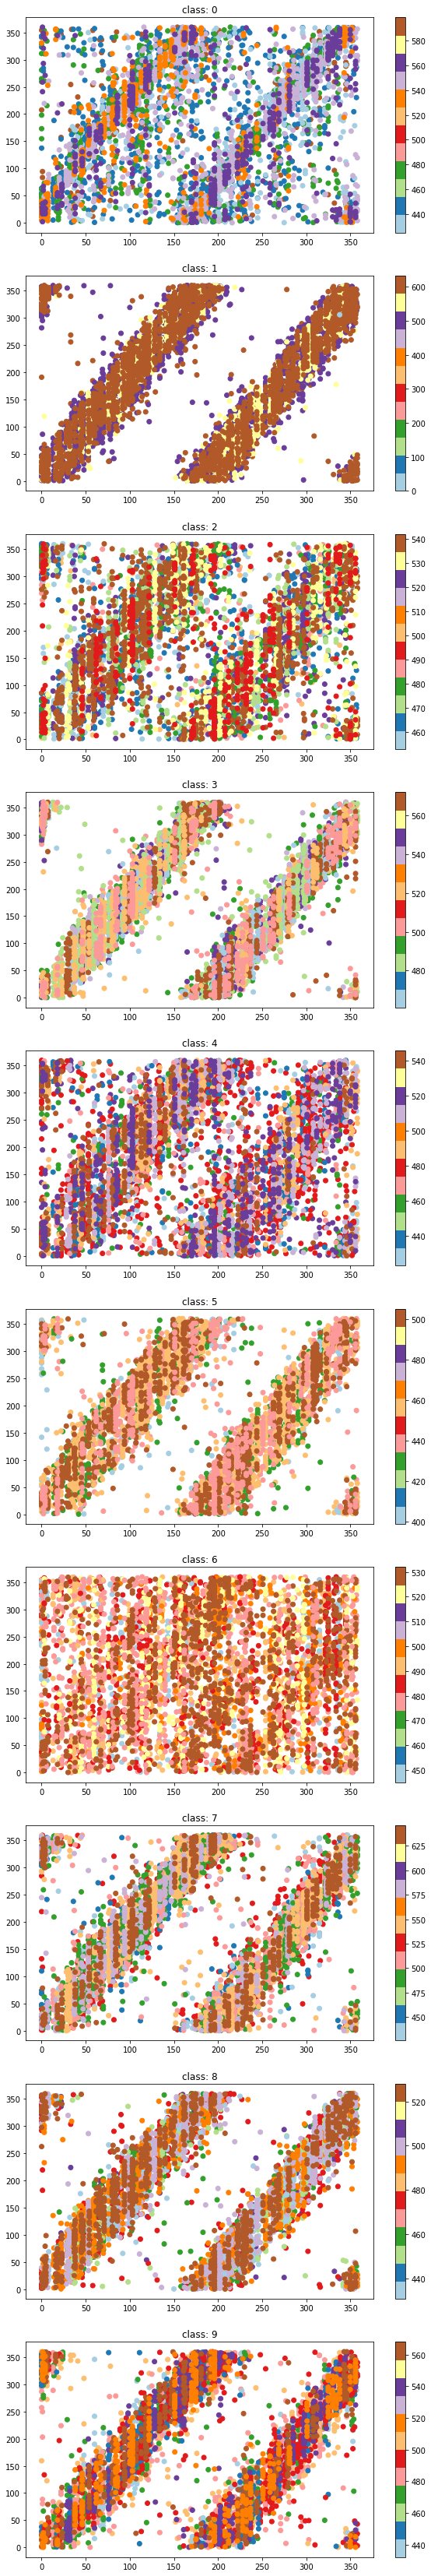

In [51]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats as stats
import scipy.spatial.distance as bla

######################################################################

solver = torch.load("../results/show_oswin/29/model_TD_CVAE_THETAS_MNIST_train_loss=158.23_z=2.pt", map_location='cpu')
solver.model.eval()

N, M = solver.y_space.shape[1], solver.y_space.shape[0]
M = 2
alphas = np.zeros((N, M))
thetas = np.zeros_like(alphas)
alphas[:, 0] = torch.atan2(torch.tensor(solver.y_space[0, :, 0]-np.mean(solver.y_space[0, :, 0])),\
            torch.tensor(solver.y_space[0, :, 1]-np.mean(solver.y_space[0, :, 1])))
alphas[:, 1] = torch.atan2(torch.tensor(solver.y_space[1, :, 0]-np.mean(solver.y_space[1, :, 0])),\
            torch.tensor(solver.y_space[1, :, 1]-np.mean(solver.y_space[1, :, 1])))
alphas = np.array(alphas)
alphas[:, 1] -= alphas[:, 0]
alphas /= (2*np.pi)/360
alphas = np.around(alphas, decimals=2)
thetas[:, 0] = solver.data_loader.prepro_params["theta_1"][0]
thetas[:, 1] = solver.data_loader.prepro_params["theta_1"][1]
alphas = np.where(alphas >= 0, alphas, alphas+360)

print(thetas[:, 0])
print(thetas[:, 1])

'''
M=1
alphas = torch.zeros((N, 1))
thetas = np.zeros_like(alphas)
alphas[:, 0] = torch.atan2(torch.tensor(solver.y_space[0, :, 0]-np.mean(solver.y_space[0, :, 0])),\
            torch.tensor(solver.y_space[0, :, 1]-np.mean(solver.y_space[0, :, 1])))/(2*np.pi)
alphas = np.around(np.array(alphas), decimals=2)
thetas[:, 0] = solver.data_loader.prepro_params["theta_1"][0]
'''

'''
N, M = solver.y_space.shape[1], solver.y_space.shape[0]
alphas = torch.zeros((N, M))
thetas = np.zeros_like(alphas)
for idx in range(M):
    alphas[:, idx] = torch.atan2(torch.tensor(solver.y_space[idx, :, 0]-np.mean(solver.y_space[idx, :, 0])),\
            torch.tensor(solver.y_space[idx, :, 1]-np.mean(solver.y_space[idx, :, 1])))/(2*np.pi)
    thetas[:, idx] = solver.data_loader.prepro_params["theta_1"][idx]
    alphas = np.around(np.array(alphas), decimals=2)
    if idx > 0:
        alphas[:, idx] -= alphas[:, 0]
        #neg_indices = np.where(alphas[:, idx] < -0.5)
        #pos_indices = np.where(alphas[:, idx] > 0.5)
        #alphas[neg_indices, idx] = mini % alphas[neg_indices, idx]
        #alphas[pos_indices, idx] = maxi % alphas[pos_indices, idx]
alphas = np.around(np.array(alphas), decimals=2)
'''
#solver = torch.load("../results/show_oswin/29/model_TD_CVAE_THETAS_MNIST_train_loss=158.23_z=2.pt", map_location='cpu')
#solver.model.eval()

mini = np.min(alphas)
maxi = np.max(alphas)
# create the alphas bins, corresponding to the same number as theta bins
alpha_ranges = np.around(np.linspace(mini, maxi, 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
print(alphas.shape)
# figures
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
classes = solver.data_labels
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices, 1:] # , 1:
    for i in range(alphas_indices.shape[1]):
        print(i, alphas_indices.shape)
        for alpha in alphas_indices[:, i]:
            for bin_idx, (x, y) in enumerate(alpha_bins):
                if x <= alpha and alpha < y:
                    counts[bin_idx] += 1
                    break
    new_counts = np.zeros(np.prod(alphas_indices.shape))
    asd = 0
    for idx, _ in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    thets = thetas[indices, 1:] # , 1:
    #print(len(thetas[indices].flatten()), len(alphas_indices), new_counts.shape, indices.shape)
    print(len(thets.flatten()), len(alphas_indices.flatten()))
    scatter = ax.scatter(thets.flatten(), alphas_indices.flatten(), c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)

[173. 173. 173. 173. 173. 173. 173. 173. 173. 173. 173. 173. 173. 173.
 173. 173. 173. 173. 173. 173. 173. 173. 173. 173. 173. 173. 173. 173.
 152. 152. 152. 152. 152. 152. 152. 152. 152. 152. 152. 152. 152. 152.
 152. 152. 152. 152. 152. 152. 152. 152. 152. 152. 152. 152. 152. 152.
 152. 152. 152. 152. 152. 152. 152. 152. 152. 152. 152. 152. 152. 152.
 152. 152. 152. 152. 152. 152. 152. 152. 152. 152. 152. 152. 152. 152.
 152. 152. 152. 152. 152. 152. 152. 152. 152. 152. 152. 152. 152. 152.
 152. 152.]
(10, 59904, 2)
(59904, 10) 0.0 359.99875
thetas (59904, 10) -4.02096 3.6181605
[  0. 152. 303. 284.  10. 109. 117. 243. 345. 213.] [  0.        53.03502  185.44568  314.07794  300.74933   97.54977
 208.37442   85.145325 121.70696   13.394246]


'\nmini = np.min(alphas)\nmaxi = np.max(alphas)\n# create the alphas bins, corresponding to the same number as theta bins\nalpha_ranges = np.around(np.linspace(mini, maxi, 13), decimals=2)\nalpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins\nprint(alphas.shape)\n# figures\nfig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))\nclasses = solver.data_labels\nfor ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):\n    indices = np.where(classes == label)[0]\n    ax.set_title("class: {}".format(label))\n    counts = np.zeros(len(alpha_bins))\n    alphas_indices = alphas[indices] # , 1:\n    for i in range(alphas_indices.shape[1]):\n        print(i, alphas_indices.shape)\n        for alpha in alphas_indices[:, i]:\n            for bin_idx, (x, y) in enumerate(alpha_bins):\n                if x <= alpha and alpha < y:\n                    counts[bin_idx] += 1\n                    break\n    new_counts = np.zeros(np.prod(alphas_indi

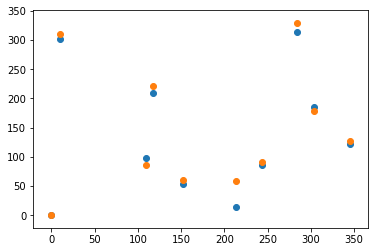

In [46]:
'''
#compute alphas
ysflat=np.reshape(ys,(ys.shape[0]*ys.shape[1] * ys.shape[2],2))
meany=np.mean(ysflat,0,keepdims=True)
alphas= np.arctan2(ysflat[:,1]-meany[:,1], ysflat[:,0]-meany[:,0])
alphas= np.reshape(alphas,(ys.shape[0] * s.shape[0], theta.shape[0]))

#normalize alpha[0]=theta[0]=0
alphas -= alphas[:,0:1]
alphas = alphas/(2*np.pi) * 360
alphas = np.where(alphas > 0, alphas, alphas+360)
'''
solver = torch.load("../results/show_oswin/29/model_TD_CVAE_THETAS_MNIST_train_loss=158.23_z=2.pt", map_location='cpu')
solver.model.eval()

print(solver.data_loader.prepro_params["theta_1"][1][100:200])
print(solver.y_space.shape)
N, M = solver.y_space.shape[1], solver.y_space.shape[0]
# M, N, 2
ysflat = np.reshape(solver.y_space, (N*M, 2)) # NM, 2
meany = np.mean(ysflat, 0, keepdims=True) # 1, 2
alphas = np.arctan2(ysflat[:,1]-meany[:,1], ysflat[:,0]-meany[:,0])
alphas = np.reshape(alphas, (M, N)).T # 20*5, 30
alphas -= alphas[:,0:1]
alphas = alphas/(2*np.pi) * 360
alphas = np.where(alphas >= 0, alphas, alphas+360)
thetas = solver.data_loader.prepro_params["theta_1"].T # M, N
print(alphas.shape, np.min(alphas), np.max(alphas))
print("thetas", thetas.shape, np.min(ysflat), np.max(ysflat))

#scatter = ax.scatter(thetas.flatten(), alphas.flatten())
print(thetas[200,:], alphas[200,:])
plt.scatter(thetas[200,:], alphas[200,:])
plt.scatter(thetas[201,:], alphas[201,:])
'''
for idx in range(M):
    alphas[:, idx] = torch.atan2(torch.tensor(solver.y_space[idx, :, 0]-np.mean(solver.y_space[idx, :, 0])),\
            torch.tensor(solver.y_space[idx, :, 1]-np.mean(solver.y_space[idx, :, 1])))/(2*np.pi)
    thetas[:, idx] = solver.data_loader.prepro_params["theta_1"][idx]
    alphas = np.around(np.array(alphas), decimals=2)
    if idx > 0:
        alphas[:, idx] -= alphas[:, 0]
alphas = np.around(np.array(alphas), decimals=2)
'''

'''
mini = np.min(alphas)
maxi = np.max(alphas)
# create the alphas bins, corresponding to the same number as theta bins
alpha_ranges = np.around(np.linspace(mini, maxi, 13), decimals=2)
alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
print(alphas.shape)
# figures
fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10,60))
classes = solver.data_labels
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(alpha_bins))
    alphas_indices = alphas[indices] # , 1:
    for i in range(alphas_indices.shape[1]):
        print(i, alphas_indices.shape)
        for alpha in alphas_indices[:, i]:
            for bin_idx, (x, y) in enumerate(alpha_bins):
                if x <= alpha and alpha < y:
                    counts[bin_idx] += 1
                    break
    new_counts = np.zeros(np.prod(alphas_indices.shape))
    asd = 0
    for idx, _ in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    thets = thetas[indices] # , 1:
    #print(len(thetas[indices].flatten()), len(alphas_indices), new_counts.shape, indices.shape)
    print(len(thets.flatten()), len(alphas_indices.flatten()))
    scatter = ax.scatter(thets.flatten(), alphas_indices.flatten(), c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)
'''

In [ ]:
radiuses = np.zeros((solver.y_space.shape[0], solver.num_generations))
centroid = np.mean(solver.y_space[:, :2], axis=0)
# compute the euclidean distance from each point y_{ij} to the center, so the radiuses
#print(solver.data_loader.train_loader.dataset.transform.transforms.prepro_params)
#print(solver.data_loader.prepro_params["scale_1"])
for idx, gen_idx in enumerate(range(0, solver.num_generations*2, 2)):
    radiuses[:, idx] = bla.cdist(solver.y_space[:, gen_idx:gen_idx+2], np.atleast_2d(centroid)).ravel()
    if idx > 0:
        radiuses[:, idx] -= radiuses[:, 0]
    #radiuses = np.around(np.array(radiuses), decimals=2)
    # prepare the scale from each batch, repeat each set of scales to span over num train samples
#print(solver.data_loader.prepro_params)
scales = np.zeros((solver.data_loader.num_train_samples, solver.num_generations))
for idx in range(solver.num_generations):
    #thetas[:, gen] = np.repeat(solver.data_loader.prepro_params["theta_1"][gen::solver.num_generations], solver.data_loader.batch_size)
    scales[:, idx] = np.repeat(solver.data_loader.prepro_params["scale_1"][gen::solver.num_generations], solver.data_loader.batch_size)
    # create the alphas bins, corresponding to the same number as theta bins
mini = np.min(radiuses)
maxi = np.max(radiuses)
radius_ranges = np.around(np.linspace(mini, maxi, 5), decimals=2)
radius_bins = list(zip(radius_ranges[:-1], radius_ranges[1:]))

fig, axes = plt.subplots(nrows=solver.data_loader.n_classes, figsize=(10, 60))
classes = np.array(solver.data_labels)
for ax, label in zip(axes.flat, range(solver.data_loader.n_classes)):
    indices = np.where(classes == label)[0]
    ax.set_title("class: {}".format(label))
    counts = np.zeros(len(radius_bins))
    radius_indices = radiuses[indices]
    for i in range(radiuses.shape[1]):
        for alpha in radius_indices[:, i]:
            for bin_idx, (x, y) in enumerate(radius_bins):
                if x <= alpha and alpha < y:
                    counts[bin_idx] += 1
                    break
    new_counts = np.zeros(np.prod(radius_indices.shape))
    asd = 0
    for idx, _ in enumerate(counts):
        to_fill = counts[idx].repeat(counts[idx])
        offset = len(to_fill)
        new_counts[asd:(asd+offset)] = to_fill
        asd += offset
    scatter = ax.scatter(scales[indices, :].flatten(), radius_indices.flatten(), c=new_counts, cmap=plt.cm.get_cmap("Paired", 12))
    fig.colorbar(scatter, ax=ax)

In [ ]:
last_train_loss = solver.train_loss_history["train_loss_acc"][-1]
mode = ""
if solver.data_loader.thetas and solver.data_loader.scales:
    mode = "SCALES_THETAS_"
elif solver.data_loader.thetas:
    mode += "THETAS_"
elif solver.data_loader.scales:
    mode += "SCALES_"
torch.save(solver, solver.data_loader.directories.result_dir + "/model_TD_CVAE_" + mode + solver.data_loader.dataset + "_train_loss=" + "{0:.2f}".format(last_train_loss) + "_z=" + str(solver.z_dim) + ".pt")